In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with $\lambda = 1$.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [ ]:
# Read the data
ames = pd.read_csv("/content/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [ ]:
# Set up pipeline
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

# Linear regression
lr = LinearRegression()

lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", lr)]
)

# Cross validation
cross_val_score(lr_pipeline, X, y, cv = 5, scoring = 'r2')

array([-2.59303720e+21, -1.13145211e+19, -7.57138616e+20, -4.47669752e+18,
       -2.55949915e+20])

In [ ]:
# Ridge Regression
ridge_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

# Cross-Validating
cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')

array([0.89815807, 0.91744024, 0.79493606, 0.78522563, 0.91389818])

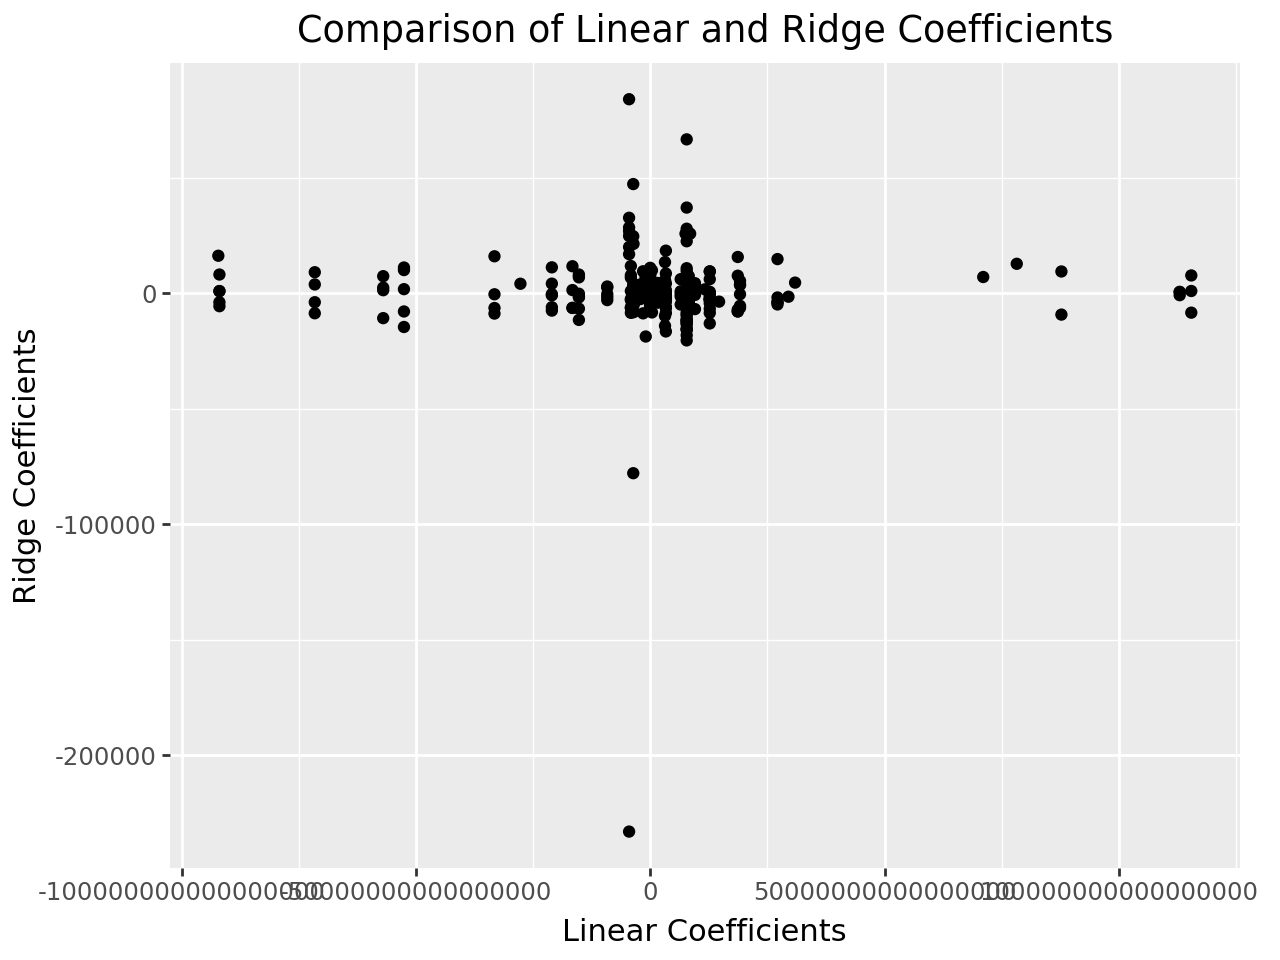

In [ ]:
# Plot of these coefficients compared to the ones from ordinary linear regression

import plotnine as p9

# Fitting both models on whole dataset
lr_fitted = lr_pipeline.fit(X, y)
ridge_fitted = ridge_pipeline.fit(X, y)

# Coefficients
lr_coefs = lr_fitted.named_steps['linear_regression'].coef_
ridge_coefs = ridge_fitted.named_steps['ridge_regression'].coef_

# Creating DataFrame for coefficients
df_coeff = pd.DataFrame({"linear": lr_coefs,
                         "ridge": ridge_coefs})

# Plotting with coefficients
(p9.ggplot(df_coeff, p9.aes(x="linear", y="ridge"))
 + p9.geom_point()
 + p9.labs(title="Comparison of Linear and Ridge Coefficients", x="Linear Coefficients", y="Ridge Coefficients"))

Using the same pipeline as previously, perform tuning on $\lambda$.

You should always try $\lambda$ values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [ ]:
# Define the lambda values on a log scale
lambda_values = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Set up GridSearchCV with the pipeline and parameter grid
gscv = GridSearchCV(ridge_pipeline, lambda_values, cv = 5, scoring = "r2")

# Fit the GridSearchCV to find the best lambda
gscv_fitted = gscv.fit(X, y)

# Converting Results to a Dataframe
results_df = pd.DataFrame(gscv_fitted.cv_results_)

# Mean test scores in descending order
ridge_results = pd.DataFrame({
    "lambda": gscv_fitted.cv_results_['param_ridge_regression__alpha'],
    "mean_test_score": gscv_fitted.cv_results_['mean_test_score']
}).sort_values(by="mean_test_score", ascending=False)

ridge_results

,lambda,mean_test_score
4,10.000,0.864272
3,1.000,0.861932
5,100.000,0.857773
2,0.100,0.856302
1,0.010,0.854186
0,0.001,0.853920


Create a LASSO pipeline, and tune $\lambda$.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [ ]:
# Lasso Pipeline
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso())]
)

# Tuning with different values of alpha (lambda)
lambda_values = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Running GridSearchCV for Lasso
gscv_lasso = GridSearchCV(lasso_pipeline, lambda_values, cv=5, scoring='r2')

# Fitting GridSearchCV on all data
lasso_fitted = gscv_lasso.fit(X, y)

# Displaying Scores in Descending Order in DataFrame
lasso_results = pd.DataFrame({
    "lambda": gscv_lasso.cv_results_['param_lasso_regression__alpha'],
    "mean_test_score": gscv_lasso.cv_results_['mean_test_score']
}).sort_values(by="mean_test_score", ascending=False)

lasso_results

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,lambda,mean_test_score
5,100.000,0.866931
4,10.000,0.860632
3,1.000,0.857152
2,0.100,0.856618
1,0.010,0.855606
0,0.001,0.855499


In [ ]:
# Transform the data for consistency
X_transformed = ct.fit_transform(X)

# Best Lasso model
lasso_model = Lasso(alpha=100)
lasso_model.fit(X_transformed, y)
lasso_coefs = lasso_model.coef_

# Ridge model with previously selected best lambda
ridge_model = Ridge(alpha=gscv.best_params_['ridge_regression__alpha'])
ridge_model.fit(X_transformed, y)
ridge_coefs = ridge_model.coef_

# OLS model (no regularization)
ols_model = LinearRegression()
ols_model.fit(X_transformed, y)
ols_coefs = ols_model.coef_

# Create a DataFrame to compare coefficients
coeff_comparison = pd.DataFrame({
    "Lasso": lasso_coefs,
    "Ridge": ridge_coefs,
    "OLS": ols_coefs
})

# Display the coefficient comparison
coeff_comparison

,Lasso,Ridge,OLS
0,-0.000000,-4906.494598,-2.241800e+13
1,0.000000,2346.943135,-2.241800e+13
2,-0.000000,-1229.177404,-2.241800e+13
3,0.000000,4620.911891,-2.241800e+13
4,0.000000,2204.285000,-2.241800e+13
...,...,...,...
249,2829.886060,3104.701760,2.720000e+03
250,791.915349,489.258612,2.816000e+03
251,-4328.443776,-4135.488058,-5.152000e+03
252,-576.052919,-638.220273,-8.160000e+02


Create an Elastic Net pipeline, and tune $\lambda$ and $\alpha$.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [ ]:
# Define the Elastic Net pipeline
elastic_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elastic_net", ElasticNet())
])

# Define parameter grid for alpha (lambda) and l1_ratio
param_grid = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'elastic_net__l1_ratio': [0.1, 0.5, 0.9]
}

# Set up GridSearchCV for Elastic Net
gscv_elastic_net = GridSearchCV(elastic_pipeline, param_grid, cv=5, scoring="r2")

# Fit GridSearchCV to find the best alpha and l1_ratio for Elastic Net
gscv_elastic_net.fit(X, y)

# Retrieve the best Elastic Net model and fit it on the full data
best_elastic_net_model = gscv_elastic_net.best_estimator_
best_elastic_net_model.fit(X, y)
elastic_net_coefs = best_elastic_net_model.named_steps['elastic_net'].coef_

# Fit Ridge and OLS models on the transformed data for comparison
ridge_model = Ridge(alpha=gscv.best_params_['ridge_regression__alpha'])
ridge_model.fit(X_transformed, y)
ridge_coefs = ridge_model.coef_

ols_model = LinearRegression()
ols_model.fit(X_transformed, y)
ols_coefs = ols_model.coef_

# Create a DataFrame to compare coefficients
coeff_comparison = pd.DataFrame({
    "ElasticNet": elastic_net_coefs,
    "Ridge": ridge_coefs,
    "OLS": ols_coefs
}, index=ct.get_feature_names_out())

# Display the coefficient comparison
coeff_comparison

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.466e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.259e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.122e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

,ElasticNet,Ridge,OLS
dummify__MS Zoning_C (all),-4367.073164,-4906.494598,-2.241800e+13
dummify__MS Zoning_FV,2589.302226,2346.943135,-2.241800e+13
dummify__MS Zoning_I (all),-919.417357,-1229.177404,-2.241800e+13
dummify__MS Zoning_RH,3853.919064,4620.911891,-2.241800e+13
dummify__MS Zoning_RL,2216.939257,2204.285000,-2.241800e+13
...,...,...,...
standardize__Screen Porch,3119.443565,3104.701760,2.720000e+03
standardize__Pool Area,410.933060,489.258612,2.816000e+03
standardize__Misc Val,-4159.204931,-4135.488058,-5.152000e+03
standardize__Mo Sold,-614.755896,-638.220273,-8.160000e+02
